In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import glob
import os
import re

Creating the mergedcount data for the PCA and DGE Plots

In [9]:
files = glob.glob("data/*.readCounts.txt")
dfs = []

for f in files:
    # sample name from filename
    name = os.path.basename(f)
    sample = re.sub(r"\.readCounts\.txt$", "", name)
    sample = sample.split("_", 1)[1]   # optional: remove GSM prefix
    
    # load file, robust to spaces or tabs
    df = pd.read_csv(
        f, 
        sep=r"\s+",          # handles tab OR spaces
        header=None, 
        names=["gene", sample],
        engine="python"      # needed for regex separators
    )
    
    dfs.append(df)

# Merge all files by gene
merged = dfs[0]
for df in dfs[1:]:
    merged = merged.merge(df, on="gene", how="outer")

# Replace NaNs with zeros
merged = merged.fillna(0)

merged.to_csv("merged_counts_matrix.txt", sep="\t", index=False)

Figure 1: PCA Plot

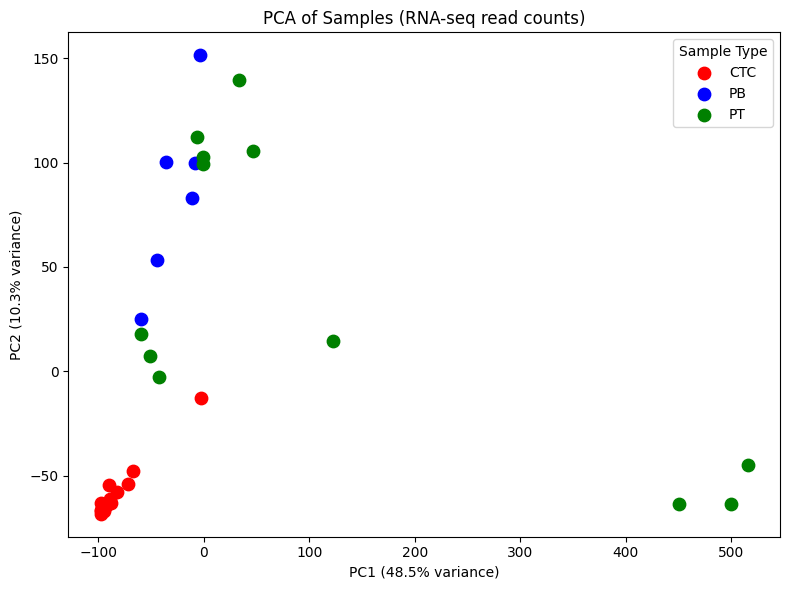

In [10]:
# 1. Load merged count matrix
df = pd.read_csv("merged_counts_matrix.txt", sep="\t")

# 2. Set gene column as index
df = df.set_index("gene")

# 3. Log-transform counts (avoid log(0))
log_df = np.log2(df + 1)

# 4. Standardize features (genes)
scaler = StandardScaler()
scaled = scaler.fit_transform(log_df.T)  # transpose: samples as rows

# 5. Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled)

# 6. Extract sample names
samples = log_df.columns

# 7. Assign groups based on the first part of the name
groups = [s.split("_")[0] for s in samples]

# Rename groups: BLOOD -> PB, TUMOR -> PT
groups = ["PB" if g == "BLOOD" else "PT" if g == "TUMOR" else g for g in groups]

# 8. Create PCA DataFrame
pca_df = pd.DataFrame({
    "PC1": pca_result[:,0],
    "PC2": pca_result[:,1],
    "sample": samples,
    "group": groups
})

# 9. Define color map for groups
color_map = {
    "CTC": "red",
    "PB": "blue",
    "PT": "green"
}

# Assign colors for plotting
colors = [color_map[g] for g in pca_df["group"]]

# 10. Plot PCA
plt.figure(figsize=(8,6))

for group in sorted(pca_df["group"].unique()):
    subset = pca_df[pca_df["group"] == group]
    plt.scatter(subset["PC1"], subset["PC2"],
                color=color_map[group], label=group, s=80)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.title("PCA of Samples (RNA-seq read counts)")
plt.legend(title="Sample Type")
plt.tight_layout()
plt.savefig('pca.png')
plt.show()

**Run the DGE R Script First Before the Next Figure**

Figure 2: Differential Gene Expression Volcano Plot

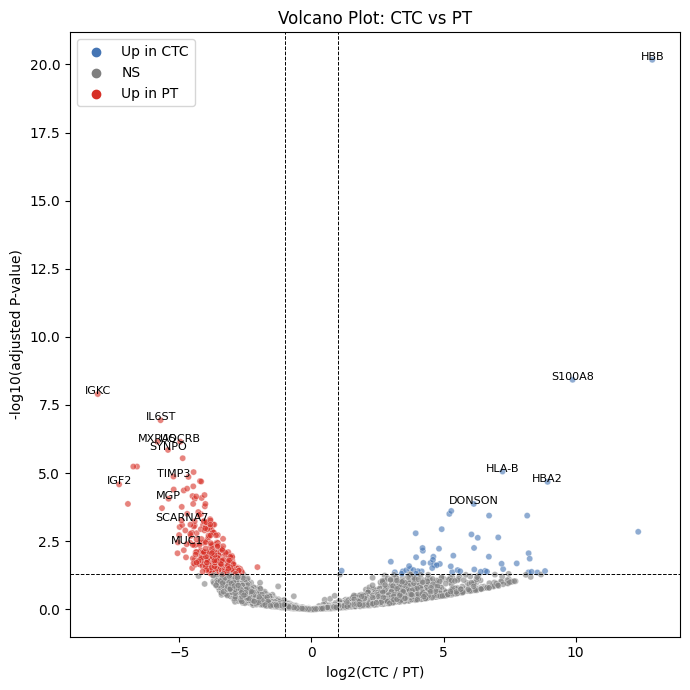

In [14]:
# ===== Load DESeq2 results exported from R =====
res = pd.read_csv("DESeq2_results_for_python.tsv", sep="\t")

# Ensure regulation is categorical with correct order
res["regulation"] = pd.Categorical(
    res["regulation"],
    categories=["Up in CTC", "NS", "Up in PT"],
    ordered=True
)

# ===== Volcano Plot =====
plt.figure(figsize=(7, 7))

sns.scatterplot(
    data=res,
    x="log2FoldChange",
    y="log10padj",
    hue="regulation",
    palette={
        "Up in CTC": "#4575B4",
        "NS": "gray",
        "Up in PT": "#D73027"
    },
    alpha=0.6,
    s=20
)

# Threshold lines
plt.axvline(x=1, linestyle="--", color="black", linewidth=0.7)
plt.axvline(x=-1, linestyle="--", color="black", linewidth=0.7)
plt.axhline(y=-np.log10(0.05), linestyle="--", color="black", linewidth=0.7)

# Add gene labels
label_df = res[res["label"].notna() & (res["label"] != "")]
for _, row in label_df.iterrows():
    plt.text(
        row["log2FoldChange"],
        row["log10padj"],
        row["label"],
        fontsize=8,
        ha="center"
    )

plt.xlabel("log2(CTC / PT)")
plt.ylabel("-log10(adjusted P-value)")
plt.title("Volcano Plot: CTC vs PT")
plt.legend(title=None)

plt.tight_layout()
plt.savefig("volcano_plot_CTC_vs_PT_python.png", dpi=300)
plt.savefig("volcano_plot_CTC_vs_PT_python.pdf")
plt.show()